In [ ]:
import os
import numpy as np
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchsummary import summary
from torch.utils.data import random_split

In [ ]:
# path to save best model
MODEL_PATH = "/content/drive/MyDrive/DL/mini_project"

In [ ]:
# BasicBlock and ResNet block in reference to https://github.com/kuangliu/pytorch-cifar
class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(
        in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                            stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_planes, self.expansion*planes,
                      kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(self.expansion*planes)
        )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

# Updated ResNet with 3 layers instead of original 4 layers architecture
class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=10):
    super(ResNet, self).__init__()
    self.in_planes = 64

    self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                            stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.linear = nn.Linear(256*block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
        layers.append(block(self.in_planes, planes, stride))
        self.in_planes = planes * block.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = F.avg_pool2d(out, 8)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out

def ResNetSmall():
  """Helper function to return 3 layer model of 4, 4, 3 block structure
  """
  return ResNet(BasicBlock, [4,4,3])

In [ ]:
# Data transformation and normalization
transforms_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

transforms_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

In [ ]:
# data loading
training_data = torchvision.datasets.CIFAR10('./CIFAR10', train=True, transform=transforms_train, download=True)
test_data = torchvision.datasets.CIFAR10('./CIFAR10', train=False, transform=transforms_test, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
batch_size = 128
validation_size = 5000
training_size = len(training_data) - validation_size

In [ ]:
# splitting training set into training and validation set
training_data, validation_data = random_split(training_data, [training_size, validation_size])

In [ ]:
# create data loader objects
train_data_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size*2)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# create model object, initialize loss, optimizer, and scheduler
net = ResNetSmall().to(device)
criterion = torch.nn.CrossEntropyLoss()
# set weight decay(L2 penalty) and momentum
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, weight_decay=0.0005, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

In [ ]:
# model summary to see number of trainable parameters
summary(net, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [ ]:
def train():
  """Training loop
  """
  train_loss = 0.0
  correct = 0
  total = 0

  net.train()
  for i, (images, labels) in enumerate(train_data_loader):
    images, labels = images.to(device), labels.to(device)
    
    optimizer.zero_grad()
    outputs = net(images)
    fit = criterion(outputs, labels)
    fit.backward()
    nn.utils.clip_grad_value_(net.parameters(), clip_value=0.1)
    optimizer.step()
    train_loss += fit.item()
    
    # accuracy
    _, pred = outputs.max(1)
    total += labels.size(0)
    correct += (pred == labels).sum()

  loss = train_loss / len(train_data_loader)
  train_acc = float(correct)/float(total)

  print(f'Training loss: {loss:.2f}, Training acc: {train_acc:.2f}')

  return loss

def validate():
  """Validation loop
  """
  global best_loss
  val_loss = 0.0
  correct = 0
  total = 0

  net.eval()
  for i, (images, labels) in enumerate(val_data_loader):
    images, labels = images.to(device), labels.to(device)

    outputs = net(images)
    fit = criterion(outputs, labels)
    val_loss += fit.item()

    # accuracy
    _, pred = outputs.max(1)
    total += labels.size(0)
    correct += (pred == labels).sum()

  loss = val_loss / len(val_data_loader)
  val_acc = float(correct)/float(total)

  print(f'Validation loss: {loss:.2f}, Validation acc: {val_acc:.2f}')

  # save model if current validation loss is less than previous best
  if loss < best_loss:
    best_loss = loss
    path = os.path.join(MODEL_PATH, f'resnet.pth')
    torch.save(net.state_dict(), path)
    print(f'Model saved at {path}...')

  return loss

In [ ]:
# driver cell to run train and validation methods
epochs = 50
train_loss_history = []
val_loss_history = []
best_loss = np.inf

for epoch in range(epochs):
  print(f'Epoch {epoch}:')
  train_loss_history.append(train())
  val_loss_history.append(validate())
  scheduler.step()
  print(f'*'*10)

Epoch 0:
Training loss: 1.43, Training acc: 0.47
Validation loss: 1.22, Validation acc: 0.57
**********
Epoch 1:
Training loss: 0.95, Training acc: 0.66
Validation loss: 0.86, Validation acc: 0.70
**********
Epoch 2:
Training loss: 0.75, Training acc: 0.74
Validation loss: 0.84, Validation acc: 0.70
**********
Epoch 3:
Training loss: 0.62, Training acc: 0.78
Validation loss: 1.00, Validation acc: 0.69
**********
Epoch 4:
Training loss: 0.54, Training acc: 0.81
Validation loss: 0.65, Validation acc: 0.78
**********
Epoch 5:
Training loss: 0.49, Training acc: 0.83
Validation loss: 0.58, Validation acc: 0.81
**********
Epoch 6:
Training loss: 0.44, Training acc: 0.85
Validation loss: 0.49, Validation acc: 0.84
**********
Epoch 7:
Training loss: 0.40, Training acc: 0.86
Validation loss: 0.50, Validation acc: 0.84
**********
Epoch 8:
Training loss: 0.37, Training acc: 0.87
Validation loss: 0.58, Validation acc: 0.82
**********
Epoch 9:
Training loss: 0.34, Training acc: 0.88
Validation loss

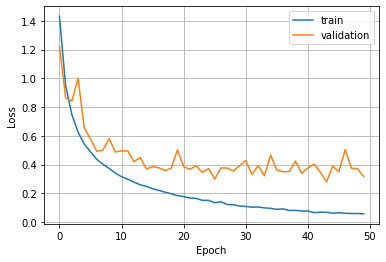

In [ ]:
# train-val loss curves
plt.plot(range(epochs), train_loss_history, '-', label="train")
plt.plot(range(epochs), val_loss_history, '-', label="validation")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.savefig("/content/drive/MyDrive/DL/mini_project/resnet_3layer_443.jpg")

In [ ]:
# load best model
net = torch.load(os.path.join(MODEL_PATH, f'resnet.pth'))
net.to(device)

In [ ]:
# test accuracy
correct = 0
samples = 0
with torch.no_grad():
  for i, (images, labels) in enumerate(test_data_loader):
    images, labels = images.to(device), labels.to(device)

    scores = net(images)
    _, pred = scores.max(1)
    correct += (pred == labels).sum()
    samples += pred.size(0)

  acc = float(correct)/float(samples)
  print(f'Test accuracy: {round(acc,2)}')

Test accuracy: 0.91
